In [122]:
import pandas as pd
import ast
from PIL import Image
import numpy as np
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

from analyze_masks import analyze_masks_and_list_exceptions

In [123]:
def categorize_data(data, column, num_categories):
    """ Categorize the data based on quantiles for a specific column """
    quantiles = data[column].quantile(np.linspace(0, 1, num_categories + 1)).drop_duplicates().sort_values()
    category_labels = [f"{int(100 * np.linspace(0, 1, len(quantiles))[i])}-{int(100 * np.linspace(0, 1, len(quantiles))[i+1])} percentile"
                       for i in range(len(quantiles)-1)]
    data[f'{column}_category'] = pd.cut(data[column], bins=quantiles, labels=category_labels, include_lowest=True)
    return data

In [124]:
def load_and_process_data(file_path, base_dir, masks_dir):
    data = pd.read_csv(file_path)
    confidence_columns = [col for col in data.columns if 'confidence' in col]
    for column in confidence_columns:
        data[column] = data[column].apply(ast.literal_eval)

    data['width'] = 0
    data['height'] = 0
    data['object_percentage'] = 0.0

    class_to_grayscale_map = analyze_masks_and_list_exceptions(masks_dir)

    for index, row in data.iterrows():
        class_id = row['id'].split('_')[0]
        picture_name = row['picture_name']
        picture_base_name = os.path.splitext(picture_name)[0]

        img_path = os.path.join(base_dir, 'train', class_id, picture_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                data.at[index, 'width'] = width
                data.at[index, 'height'] = height
        except FileNotFoundError:
            print(f"Image not found: {img_path}")

        mask_name = picture_base_name + '.png'
        mask_path = os.path.join(masks_dir, class_id, mask_name)
        try:
            with Image.open(mask_path) as mask:
                mask_array = np.array(mask)
                if class_id in class_to_grayscale_map:
                    relevant_value = class_to_grayscale_map[class_id]
                    object_pixels = np.sum(mask_array == relevant_value)
                    total_pixels = width * height
                    data.at[index, 'object_percentage'] = (object_pixels / total_pixels) * 100
        except FileNotFoundError:
            print(f"Mask not found for image: {mask_path}")

    data = categorize_data(data, 'object_percentage', 4)

    return data

In [125]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        class_dict = {}
        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            class_dict[class_id] = {
                "description": description,
                "value": row_number - 1
            }
    return class_dict

In [126]:
base_dir = '../data'
masks_dir = '../data/masks'
file_path = '../image_confidence_scores.csv'
synset_path = '../data/LOC_synset_mapping.txt'

processed_data = load_and_process_data(file_path, base_dir, masks_dir)
pd.DataFrame(processed_data).to_csv("test.csv", index=False)
class_dict = parse_synset_mapping(synset_path)

Class: n02412080, Most Common Nonzero Grayscale Value (by presence): 17, Presence Count: 982
    Images without the most common grayscale value (17): ['n02412080_13145.png', 'n02412080_1976.png', 'n02412080_6399.png', 'n02412080_16811.png', 'n02412080_2188.png', 'n02412080_19324.png', 'n02412080_18733.png', 'n02412080_2270.png', 'n02412080_16830.png', 'n02412080_16254.png', 'n02412080_26458.png', 'n02412080_3944.png', 'n02412080_1040.png', 'n02412080_10804.png', 'n02412080_13818.png', 'n02412080_11852.png', 'n02412080_791.png', 'n02412080_17063.png']
Class: n02107574, Most Common Nonzero Grayscale Value (by presence): 12, Presence Count: 997
    Images without the most common grayscale value (12): ['n02107574_3660.png', 'n02107574_142.png', 'n02107574_690.png']
Class: n01833805, Most Common Nonzero Grayscale Value (by presence): 3, Presence Count: 987
    Images without the most common grayscale value (3): ['n01833805_4117.png', 'n01833805_166.png', 'n01833805_8510.png', 'n01833805_885

In [127]:
column_names = processed_data.columns.tolist()
print(column_names)

['id', 'picture_name', 'original_confidence', 'desert_confidence', 'low_contrast_confidence', 'city_confidence', 'sky_confidence', 'jungle_confidence', 'no_bg_confidence', 'high_contrast_confidence', 'no_foreground_confidence', 'water_confidence', 'snow_confidence', 'indoor_confidence', 'mountain_confidence', 'width', 'height', 'object_percentage', 'object_percentage_category']


In [128]:
def extract_class_id_from_filename(filename):
    """Extracts the class ID from the filename."""
    return filename.split('_')[0]

In [129]:
def calculate_accuracy(data, confidence_column, class_dict):
    correct_predictions = 0
    total_predictions = 0

    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]
        
        if true_class_id in class_dict:
            true_class_value = class_dict[true_class_id]['value']
            
            predicted_confidences = row[confidence_column]
            
            if predicted_confidences:
                predicted_class_id = list(predicted_confidences[0].keys())[0]
                predicted_confidence = predicted_confidences[0][predicted_class_id]
                
                if true_class_value == predicted_class_id:
                    correct_predictions += 1
            
            total_predictions += 1
            

    return correct_predictions / total_predictions if total_predictions else 0

In [130]:
def calculate_and_print_all_accuracies(data, class_dict):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]
    accuracies = {}

    for mod_type in modification_types:
        column_name = f"{mod_type}_confidence"
        if column_name in data.columns:
            accuracy = calculate_accuracy(data, column_name, class_dict)
            accuracies[mod_type] = accuracy

    for mod_type, accuracy in accuracies.items():
        print(f"Accuracy for {mod_type} images: {accuracy:.2f}%")

In [131]:
calculate_and_print_all_accuracies(processed_data, class_dict)

Accuracy for original images: 0.89%
Accuracy for desert images: 0.76%
Accuracy for low_contrast images: 0.78%
Accuracy for city images: 0.76%
Accuracy for sky images: 0.76%
Accuracy for jungle images: 0.77%
Accuracy for no_bg images: 0.76%
Accuracy for high_contrast images: 0.78%
Accuracy for no_foreground images: 0.19%
Accuracy for water images: 0.72%
Accuracy for snow images: 0.75%
Accuracy for indoor images: 0.70%
Accuracy for mountain images: 0.70%


In [132]:
def calculate_per_class_accuracy(data, confidence_column, class_dict):
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]  
        
        if true_class_id in class_dict:
            true_class_value = class_dict[true_class_id]['value'] 

            predicted_confidences = row[confidence_column]
            if predicted_confidences:
                predicted_class_id = list(predicted_confidences[0].keys())[0] 
                predicted_confidence = predicted_confidences[0][predicted_class_id]

                class_total[true_class_value] += 1

                if true_class_value == predicted_class_id:
                    class_correct[true_class_value] += 1

    class_accuracies = {}
    for cls in class_total:
        if class_total[cls] > 0:
            class_accuracies[cls] = (class_correct[cls] / class_total[cls]) * 100

    return class_accuracies

In [133]:
def calculate_and_print_accuracies(data, class_dict):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]
    accuracies = {}
    
    for mod_type in modification_types:
        column_name = f"{mod_type}_confidence"
        if column_name in data.columns:
            accuracies[mod_type] = calculate_per_class_accuracy(data, column_name, class_dict)
    
    for mod_type, accuracy_dict in accuracies.items():
        print(f"Accuracy for {mod_type} images:")
        for cls, acc in accuracy_dict.items():
            class_id = [k for k, v in class_dict.items() if v['value'] == cls][0]
            description = class_dict[class_id]['description']
            print(f"  Class {cls} ({description}, {class_id}): {acc:.2f}%")
        print()  

In [134]:
calculate_and_print_accuracies(processed_data, class_dict)

Accuracy for original images:
  Class 348 (ram, tup, n02412080): 78.10%
  Class 238 (Greater Swiss Mountain dog, n02107574): 74.60%
  Class 94 (hummingbird, n01833805): 96.30%
  Class 285 (Egyptian cat, n02124075): 78.20%
  Class 349 (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis, n02415577): 85.70%
  Class 229 (Old English sheepdog, bobtail, n02105641): 94.10%
  Class 283 (Persian cat, n02123394): 96.40%
  Class 13 (junco, snowbird, n01534433): 97.47%
  Class 235 (German shepherd, German shepherd dog, German police dog, alsatian, n02106662): 87.40%
  Class 15 (robin, American robin, Turdus migratorius, n01558993): 98.10%

Accuracy for desert images:
  Class 348 (ram, tup, n02412080): 66.20%
  Class 238 (Greater Swiss Mountain dog, n02107574): 75.10%
  Class 94 (hummingbird, n01833805): 67.70%
  Class 285 (Egyptian cat, n02124075): 82.50%
  Class 349 (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis c

In [135]:
def calculate_dynamic_accuracy_by_category(data, confidence_columns, class_dict):
    percentage_categories = data['object_percentage_category'].unique()
    
    results = {
        category: {
            modification: defaultdict(lambda: {'total': 0, 'correct': 0})
            for modification in confidence_columns
        } for category in percentage_categories
    }
    
    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]
        
        if true_class_id in class_dict:
            true_class_value = class_dict[true_class_id]['value']
            current_category = row['object_percentage_category']
            
            for column in confidence_columns:
                predicted_confidences = row[column]
                
                if predicted_confidences:
                    predicted_class_id = list(predicted_confidences[0].keys())[0]
                    
                    results[current_category][column][true_class_value]['total'] += 1
                    
                    if true_class_value == predicted_class_id:
                        results[current_category][column][true_class_value]['correct'] += 1

    accuracies = {category: {modification: {} for modification in confidence_columns} for category in percentage_categories}
    for category in results:
        for modification in results[category]:
            for cls in results[category][modification]:
                total = results[category][modification][cls]['total']
                correct = results[category][modification][cls]['correct']
                if total > 0:
                    accuracies[category][modification][cls] = (correct / total) * 100

    return accuracies

In [136]:
def calculate_and_print_dynamic_accuracies(data, class_dict):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]

    confidence_columns = [f"{mod}_confidence" for mod in modification_types if f"{mod}_confidence" in data.columns]

    dynamic_accuracies = calculate_dynamic_accuracy_by_category(data, confidence_columns, class_dict)

    for category in dynamic_accuracies:
        print(f"\nCategory: {category}")
        for modification in dynamic_accuracies[category]:
            print(f"  Accuracy for {modification.replace('_confidence', '')} images:")
            for cls, acc in dynamic_accuracies[category][modification].items():
                class_id = [k for k, v in class_dict.items() if v['value'] == cls][0]
                description = class_dict[class_id]['description']
                print(f"    Class {cls} ({description}, {class_id}): {acc:.2f}%")
        print()

In [137]:
calculate_and_print_dynamic_accuracies(processed_data, class_dict)


Category: 0-25 percentile
  Accuracy for original images:
    Class 348 (ram, tup, n02412080): 57.39%
    Class 238 (Greater Swiss Mountain dog, n02107574): 62.96%
    Class 94 (hummingbird, n01833805): 94.28%
    Class 285 (Egyptian cat, n02124075): 60.38%
    Class 349 (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis, n02415577): 88.69%
    Class 229 (Old English sheepdog, bobtail, n02105641): 91.10%
    Class 283 (Persian cat, n02123394): 77.19%
    Class 13 (junco, snowbird, n01534433): 95.68%
    Class 235 (German shepherd, German shepherd dog, German police dog, alsatian, n02106662): 80.71%
    Class 15 (robin, American robin, Turdus migratorius, n01558993): 96.61%
  Accuracy for desert images:
    Class 348 (ram, tup, n02412080): 29.55%
    Class 238 (Greater Swiss Mountain dog, n02107574): 49.38%
    Class 94 (hummingbird, n01833805): 48.34%
    Class 285 (Egyptian cat, n02124075): 39.62%
    Class 349 (bighorn, bighorn sheep, ci

In [138]:
def calculate_and_print_most_frequent_mistakes(data, confidence_columns, class_dict):
    percentage_categories = data['object_percentage_category'].unique()
    
    results = {
        category: {
            modification: defaultdict(lambda: {'mistakes': defaultdict(int)})
            for modification in confidence_columns
        } for category in percentage_categories
    }
    
    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]
    
        if true_class_id in class_dict:
            true_class_value = class_dict[true_class_id]['value']  # Correctly using class ID to get the value
            current_category = row['object_percentage_category']
            
            for column in confidence_columns:
                predicted_confidences = row[column]
                
                if predicted_confidences:
                    predicted_class_value = list(predicted_confidences[0].keys())[0]  # Assuming this returns the class ID as string

                    if true_class_value != predicted_class_value:
                        results[current_category][column][true_class_value]['mistakes'][predicted_class_value] += 1


    for category in results:
        print(f"\nCategory: {category}")
        for modification in results[category]:
            print(f"  Most frequent mistakes for {modification.replace('_confidence', '')} images:")
            for cls in results[category][modification]:
                mistakes = results[category][modification][cls]['mistakes']
                if mistakes:
                    most_frequent_mistake = max(mistakes, key=mistakes.get)
                    mistake_count = mistakes[most_frequent_mistake]
                    class_id = [k for k, v in class_dict.items() if v['value'] == cls][0]
                    description = class_dict[class_id]['description']
                    class_id2 = [k for k, v in class_dict.items() if v['value'] == most_frequent_mistake][0]
                    description2 = class_dict[class_id2]['description']
                    print(f"    Class {cls}, ({description}) is most often mistaken for {most_frequent_mistake} ({description2}) ({mistake_count} times)")
                else:
                    print(f"    Class {cls} had no mistakes recorded.")
            print()

In [139]:
def execute_mistake_analysis(data, class_dict):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]
    
    confidence_columns = [f"{mod}_confidence" for mod in modification_types if f"{mod}_confidence" in data.columns]
    
    calculate_and_print_most_frequent_mistakes(data, confidence_columns, class_dict)

In [140]:
print(class_dict)

{'n01440764': {'description': 'tench, Tinca tinca', 'value': 0}, 'n01443537': {'description': 'goldfish, Carassius auratus', 'value': 1}, 'n01484850': {'description': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'value': 2}, 'n01491361': {'description': 'tiger shark, Galeocerdo cuvieri', 'value': 3}, 'n01494475': {'description': 'hammerhead, hammerhead shark', 'value': 4}, 'n01496331': {'description': 'electric ray, crampfish, numbfish, torpedo', 'value': 5}, 'n01498041': {'description': 'stingray', 'value': 6}, 'n01514668': {'description': 'cock', 'value': 7}, 'n01514859': {'description': 'hen', 'value': 8}, 'n01518878': {'description': 'ostrich, Struthio camelus', 'value': 9}, 'n01530575': {'description': 'brambling, Fringilla montifringilla', 'value': 10}, 'n01531178': {'description': 'goldfinch, Carduelis carduelis', 'value': 11}, 'n01532829': {'description': 'house finch, linnet, Carpodacus mexicanus', 'value': 12}, 'n01534433': {'descript

In [141]:
execute_mistake_analysis(processed_data, class_dict)


Category: 0-25 percentile
  Most frequent mistakes for original images:
    Class 348, (ram, tup) is most often mistaken for 349 (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis) (61 times)
    Class 238, (Greater Swiss Mountain dog) is most often mistaken for 241 (EntleBucher) (15 times)
    Class 94, (hummingbird) is most often mistaken for 95 (jacamar) (4 times)
    Class 285, (Egyptian cat) is most often mistaken for 281 (tabby, tabby cat) (3 times)
    Class 349, (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis) is most often mistaken for 348 (ram, tup) (22 times)
    Class 229, (Old English sheepdog, bobtail) is most often mistaken for 203 (West Highland white terrier) (2 times)
    Class 283, (Persian cat) is most often mistaken for 332 (Angora, Angora rabbit) (3 times)
    Class 13, (junco, snowbird) is most often mistaken for 12 (house finch, linnet, Carpodacus mexicanus) (3 times)

In [142]:
def calculate_average_confidence(data, confidence_column):
    correct_confidences = []
    incorrect_confidences = []
    
    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]
        true_class_value = class_dict[true_class_id]['value']
        predicted_confidences = row[confidence_column]
        
        if predicted_confidences:
            predicted_class_value = list(predicted_confidences[0].keys())[0]
            predicted_confidence = predicted_confidences[0][predicted_class_value]
            
            if true_class_value == predicted_class_value:
                correct_confidences.append(predicted_confidence)
            else:
                incorrect_confidences.append(predicted_confidence)
    
    average_correct_confidence = sum(correct_confidences) / len(correct_confidences) if correct_confidences else 1
    average_incorrect_confidence = sum(incorrect_confidences) / len(incorrect_confidences) if incorrect_confidences else 0
    
    return average_correct_confidence, average_incorrect_confidence


In [143]:
def execute_and_print_confidence_analysis(data):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]

    confidence_columns = [f"{mod}_confidence" for mod in modification_types if f"{mod}_confidence" in data.columns]
    
    for column in confidence_columns:
        average_correct, average_incorrect = calculate_average_confidence(data, column)
        print(f"{column.replace('_confidence', '').capitalize()} Modification:")
        print(f"  Average Correct Confidence: {average_correct:.2f}%")
        print(f"  Average Incorrect Confidence: {average_incorrect:.2f}%")
        print()  

In [144]:
execute_and_print_confidence_analysis(processed_data)

Original Modification:
  Average Correct Confidence: 89.16%
  Average Incorrect Confidence: 54.33%

Desert Modification:
  Average Correct Confidence: 84.31%
  Average Incorrect Confidence: 49.77%

Low_contrast Modification:
  Average Correct Confidence: 86.43%
  Average Incorrect Confidence: 46.96%

City Modification:
  Average Correct Confidence: 84.23%
  Average Incorrect Confidence: 38.89%

Sky Modification:
  Average Correct Confidence: 84.90%
  Average Incorrect Confidence: 48.47%

Jungle Modification:
  Average Correct Confidence: 85.86%
  Average Incorrect Confidence: 47.17%

No_bg Modification:
  Average Correct Confidence: 85.34%
  Average Incorrect Confidence: 39.40%

High_contrast Modification:
  Average Correct Confidence: 86.39%
  Average Incorrect Confidence: 45.79%

No_foreground Modification:
  Average Correct Confidence: 67.08%
  Average Incorrect Confidence: 34.87%

Water Modification:
  Average Correct Confidence: 80.53%
  Average Incorrect Confidence: 43.06%

Snow 

In [145]:
def plot_confidence_distribution(data, confidence_column):
    correct_confidences = []
    incorrect_confidences = []
    
    for index, row in data.iterrows():
        true_class_id = row['id'].split('_')[0]
        true_class_value = class_dict[true_class_id]['value']
        predicted_confidences = row[confidence_column]
        
        if predicted_confidences:
            predicted_class_value = list(predicted_confidences[0].keys())[0]
            predicted_confidence = predicted_confidences[0][predicted_class_value]
            
            if true_class_value == predicted_class_value:
                correct_confidences.append(predicted_confidence)
            else:
                incorrect_confidences.append(predicted_confidence)

    plt.figure(figsize=(12, 6))
    sns.histplot(correct_confidences, color='green', label='Correct Predictions', kde=True)
    sns.histplot(incorrect_confidences, color='red', label='Incorrect Predictions', kde=True)
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title(f'Confidence Distribution for {confidence_column.replace("_confidence", "").capitalize()} Images')
    plt.legend()
    plt.show()


In [146]:
def execute_and_print_confidence_distribution(data):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]
    
    confidence_columns = [f"{mod}_confidence" for mod in modification_types if f"{mod}_confidence" in data.columns]
    
    for column in confidence_columns:
        print(f"\nPlotting confidence distribution for {column.replace('_confidence', '').capitalize()} Images:")
        plot_confidence_distribution(data, column)


Plotting confidence distribution for Original Images:


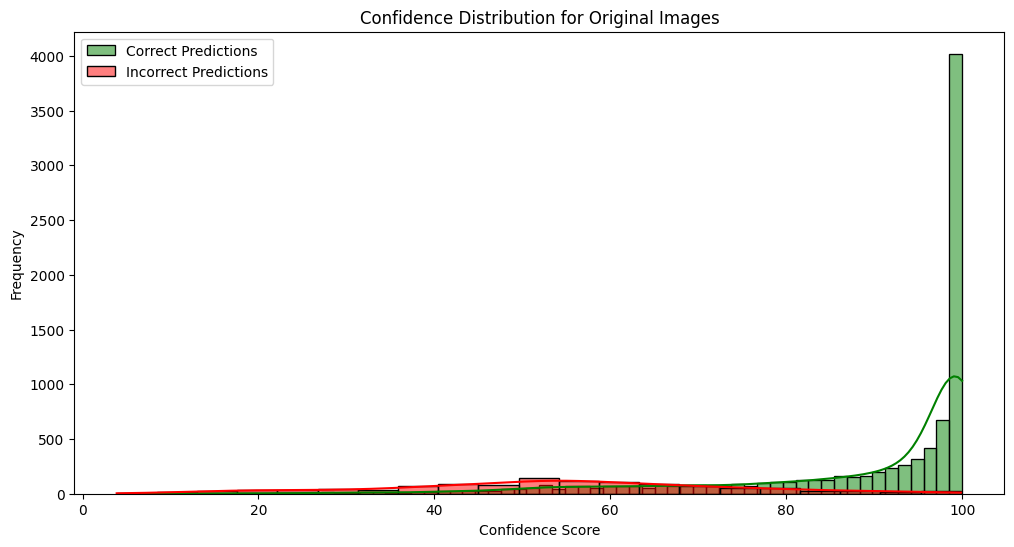


Plotting confidence distribution for Desert Images:


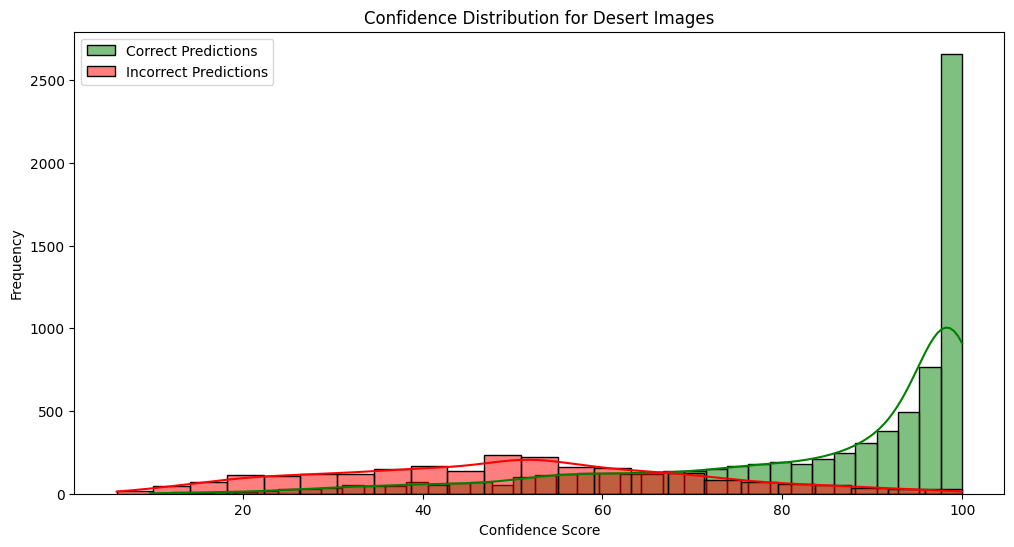


Plotting confidence distribution for Low_contrast Images:


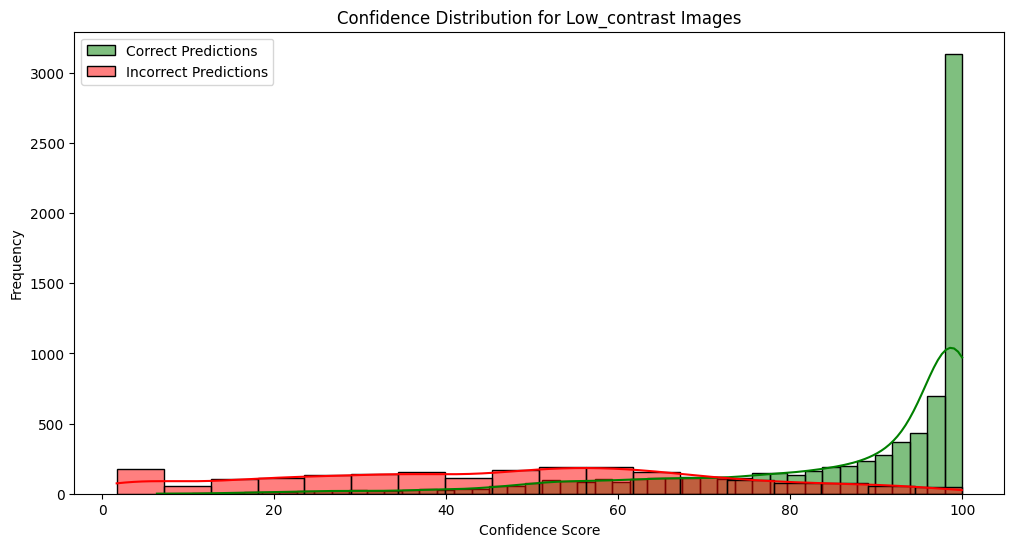


Plotting confidence distribution for City Images:


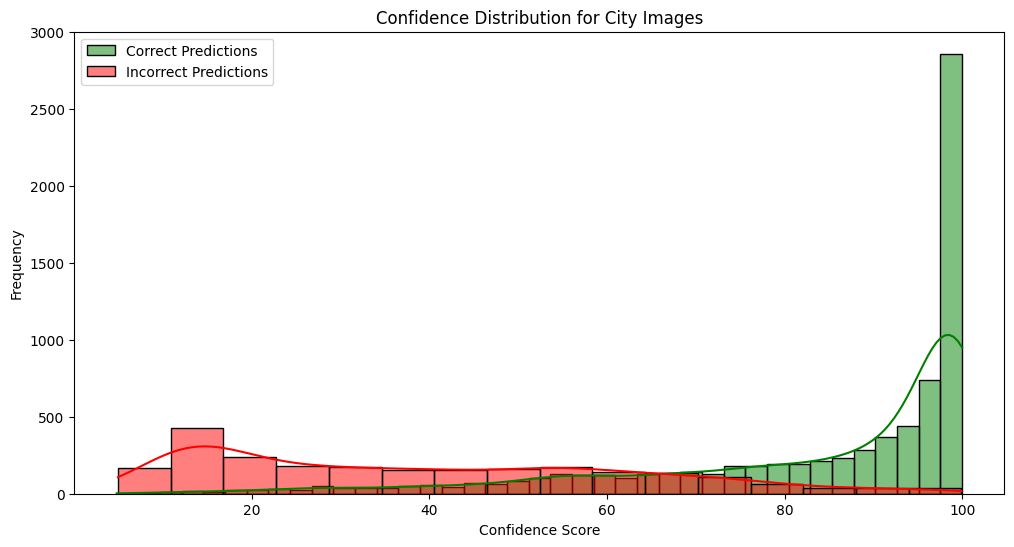


Plotting confidence distribution for Sky Images:


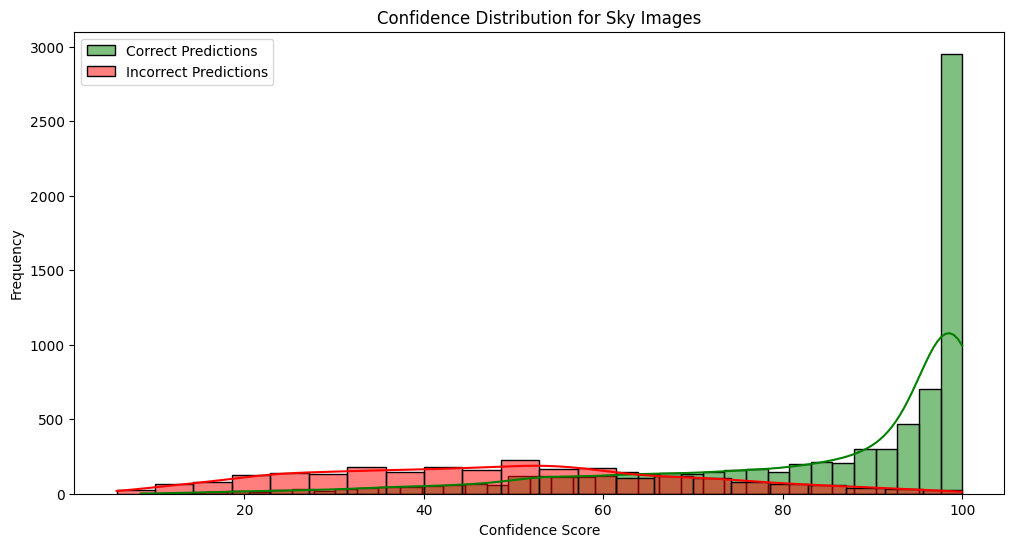


Plotting confidence distribution for Jungle Images:


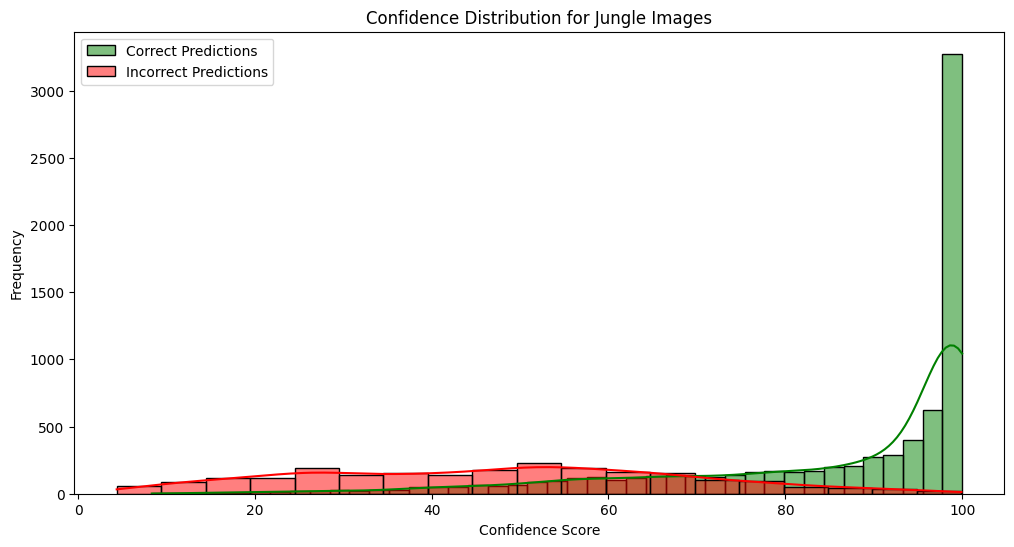


Plotting confidence distribution for No_bg Images:


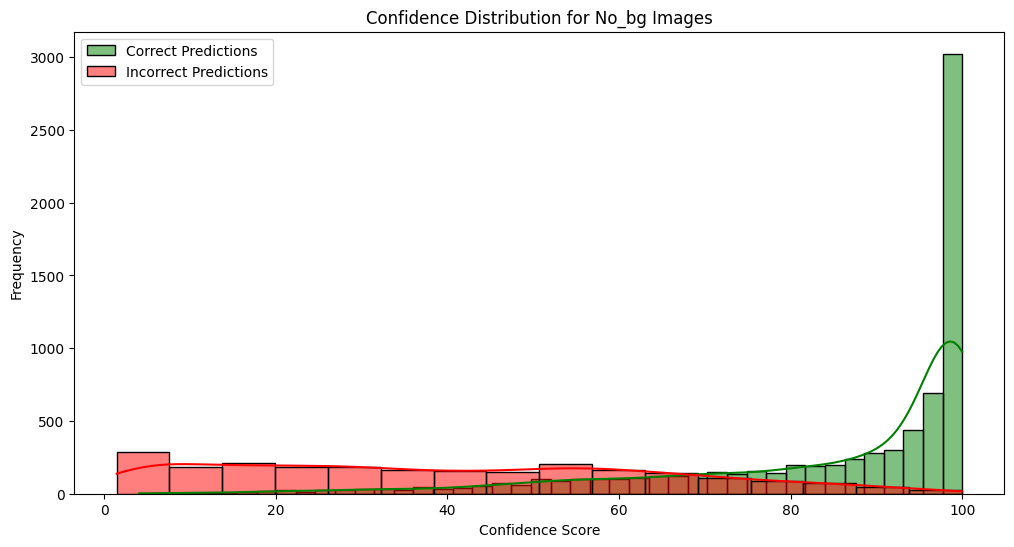


Plotting confidence distribution for High_contrast Images:


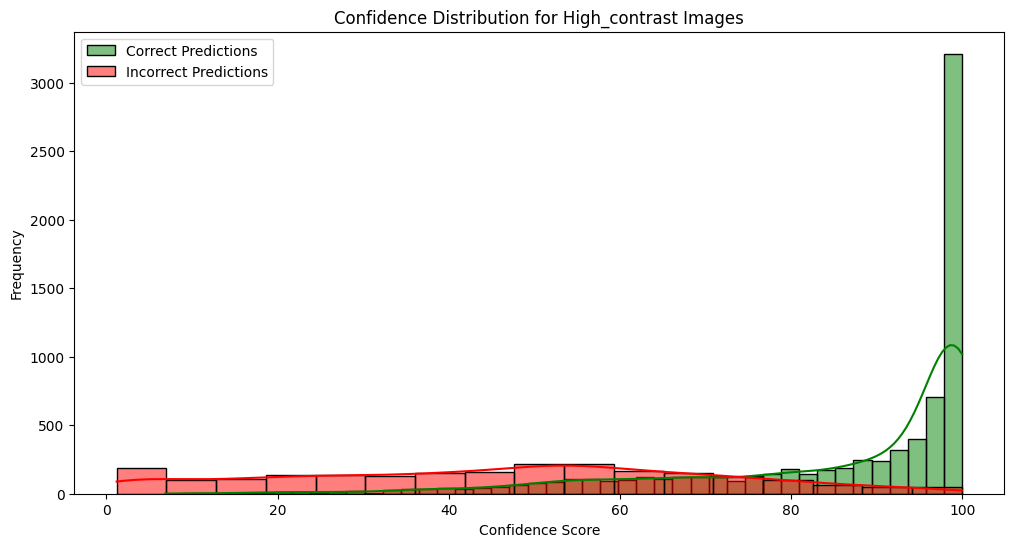


Plotting confidence distribution for No_foreground Images:


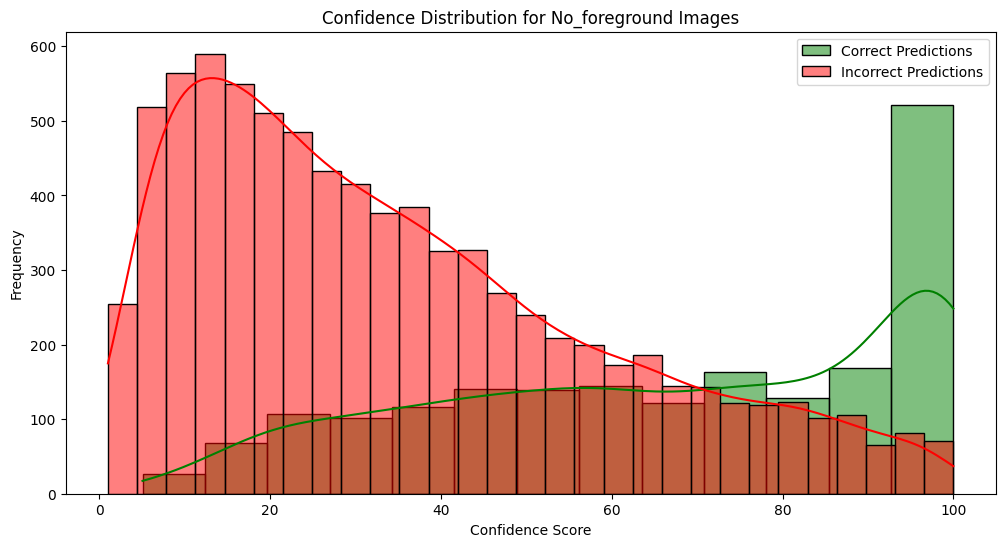


Plotting confidence distribution for Water Images:


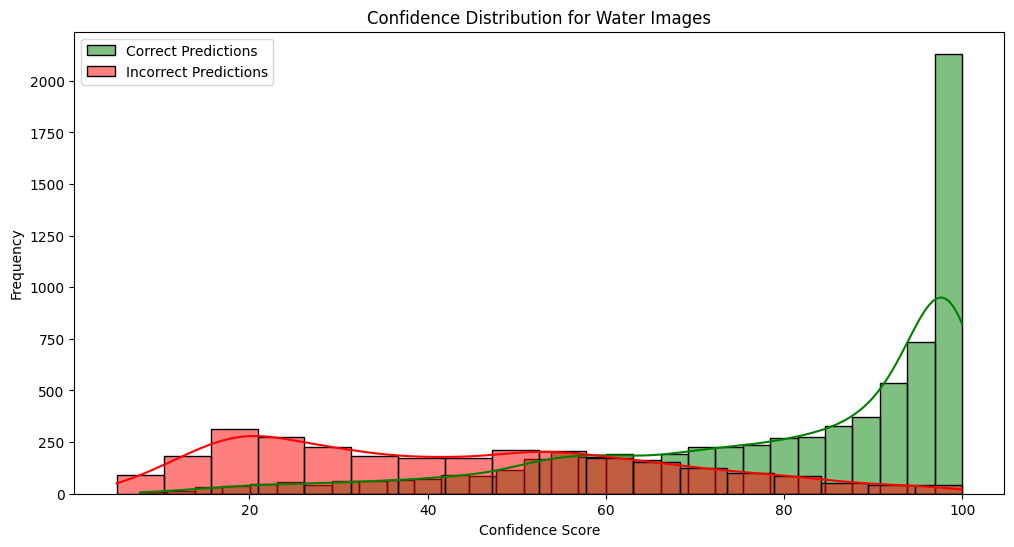


Plotting confidence distribution for Snow Images:


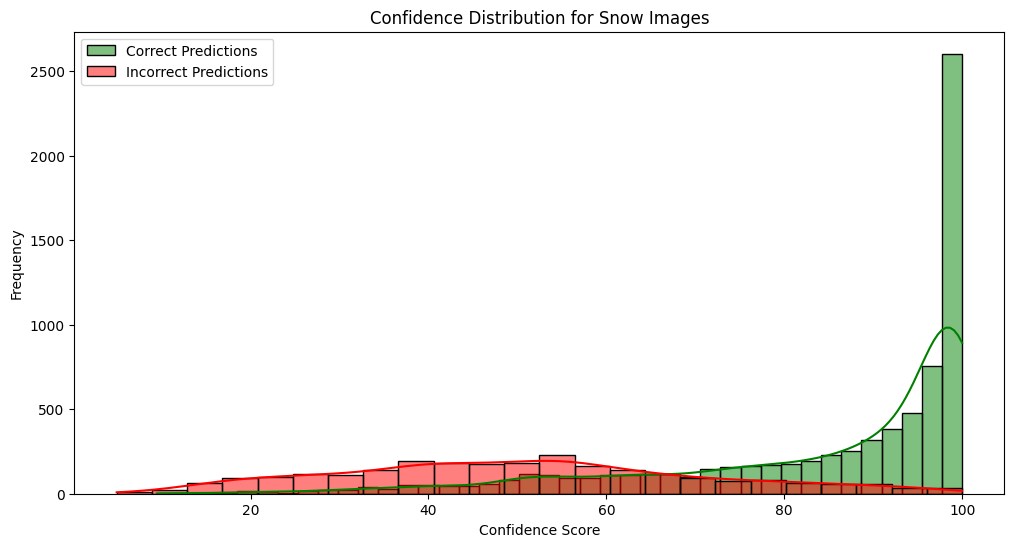


Plotting confidence distribution for Indoor Images:


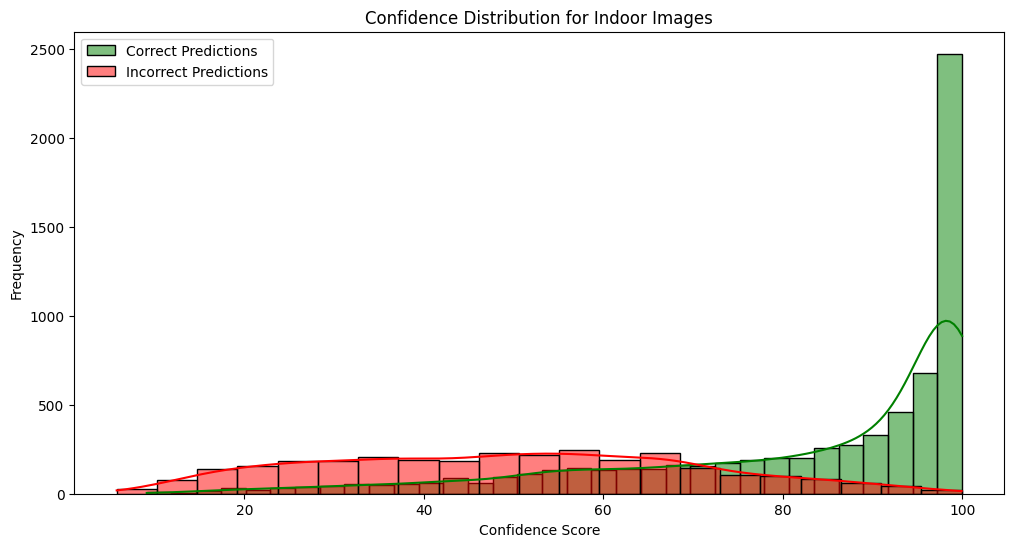


Plotting confidence distribution for Mountain Images:


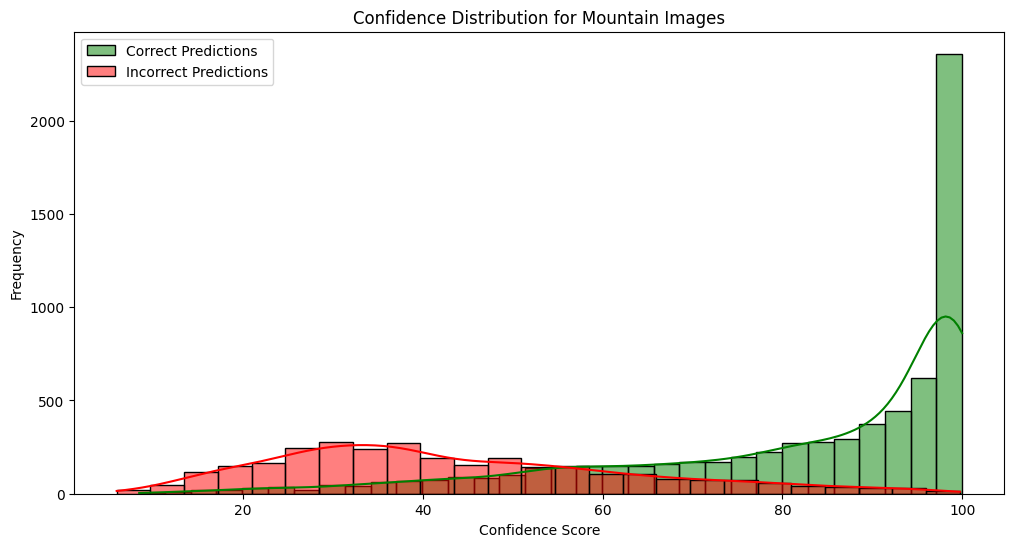

In [147]:
execute_and_print_confidence_distribution(processed_data)

In [148]:
def analyze_confidence_by_category(data, confidence_columns):
    categories_results = {}
    for category in data['object_percentage_category'].unique():
        category_data = data[data['object_percentage_category'] == category]
        categories_results[category] = {}
        for column in confidence_columns:
            average_correct, average_incorrect = calculate_average_confidence(category_data, column)
            categories_results[category][column] = {
                'average_correct_confidence': average_correct,
                'average_incorrect_confidence': average_incorrect
            }
    
    for category, results in categories_results.items():
        print(f"\nCategory: {category}")
        for modification, scores in results.items():
            print(f"  {modification.replace('_confidence', '').capitalize()} Modification:")
            print(f"    Average Correct Confidence: {scores['average_correct_confidence']:.2f}%")
            print(f"    Average Incorrect Confidence: {scores['average_incorrect_confidence']:.2f}%")
        print()  # Adds a newline for better readability


In [149]:
def execute_and_print_confidence_by_category(data):
    modification_types = [
        'original', 'desert', 'low_contrast', 'city', 'sky', 'jungle',
        'no_bg', 'high_contrast', 'no_foreground', 'water', 'snow', 'indoor', 'mountain'
    ]
    
    confidence_columns = [f"{mod}_confidence" for mod in modification_types if f"{mod}_confidence" in data.columns]
    
    print("\nAnalyzing confidence scores across object percentage categories:")
    analyze_confidence_by_category(data, confidence_columns)


In [150]:
execute_and_print_confidence_by_category(processed_data)


Analyzing confidence scores across object percentage categories:

Category: 0-25 percentile
  Original Modification:
    Average Correct Confidence: 89.94%
    Average Incorrect Confidence: 50.99%
  Desert Modification:
    Average Correct Confidence: 78.43%
    Average Incorrect Confidence: 48.07%
  Low_contrast Modification:
    Average Correct Confidence: 84.30%
    Average Incorrect Confidence: 37.36%
  City Modification:
    Average Correct Confidence: 76.92%
    Average Incorrect Confidence: 27.03%
  Sky Modification:
    Average Correct Confidence: 82.81%
    Average Incorrect Confidence: 44.45%
  Jungle Modification:
    Average Correct Confidence: 85.96%
    Average Incorrect Confidence: 40.07%
  No_bg Modification:
    Average Correct Confidence: 83.30%
    Average Incorrect Confidence: 28.63%
  High_contrast Modification:
    Average Correct Confidence: 84.66%
    Average Incorrect Confidence: 35.93%
  No_foreground Modification:
    Average Correct Confidence: 73.07%
    A